In [2]:
import pandas as pd
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt
from diffusion_and_model import Diffusion_without_class,sample,p_losses
from torch import nn, einsum, optim
import torch
import tqdm
import os
# Enable plots inside the Jupyter NotebookLet the
%matplotlib inline
timesteps =1000

In [3]:
model = Diffusion_without_class()

In [4]:
train_image = np.load("cifar10_train_image.npy")
train_label = np.load("cifar10_train_label.npy")
image_1000 = np.array(train_image[:1000])
labels_1000 =np.array(train_label[:1000])
train_image_transform = train_image/255.0*2-1

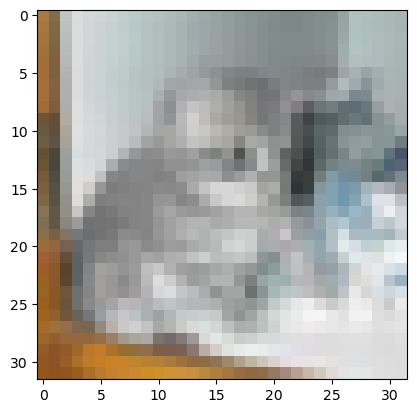

In [9]:
source = torch.tensor(train_image_transform[36:37].transpose([0,3,1,2]).astype(np.float32))
plt.imshow((source[0].numpy().transpose(1,2,0)+1.0)/2.0)

In [10]:
model.load_state_dict(torch.load('cifar10_diffusion_without_class_model_epoch_10000_dataset_1000_sample_1000_time.pth'))

<All keys matched successfully>

torch.Size([1, 3, 32, 32])


sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1000
torch.Size([1, 3, 32, 32])


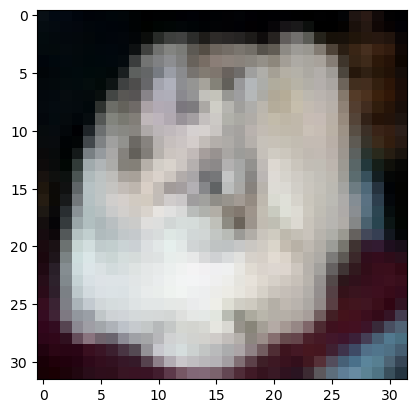

In [11]:
samples = sample(model, image_size=32, batch_size=1, channels=3)

# Get the last sample and normalize it in [0,1]
# last_sample = (samples[-1] - samples[-1].min())/(samples[-1].max()-samples[-1].min())
last_sample = samples[-1]
print(len(samples))
print(last_sample.shape)
plt.imshow((last_sample[0].numpy().transpose(1,2,0)+1.0)/2.0)

In [12]:
from torch import nn, einsum, optim
import torch
import tqdm
class generalized_inverse(nn.Module):
    def __init__(self):
        super().__init__()
        self.avgpool2d = nn.AvgPool2d(2)
        self.upsample = nn.Upsample(scale_factor=2)
        self.w = nn.parameter.Parameter(torch.zeros((1,3,32,32)))

    def forward(self,Ms):
        #B`Z + (I-B`B)W
        Bg_iZ=self.upsample(Ms)
        Bg_iBW = self.upsample(self.avgpool2d(self.w))
        W_Bg_iBW = self.w - Bg_iBW

        return Bg_iZ +W_Bg_iBW 

    def A_(self,source):
        
        Ms = self.avgpool2d(source)
        return Ms


In [15]:
import torch
for index in range(10):

    source = torch.tensor(train_image_transform[30+index:31+index].transpose([0,3,1,2]).astype(np.float32))

    device = "cuda"
    model=model.to(device)
    g_i =  generalized_inverse()
    g_i = g_i.to("cuda")
    source = source.to("cuda")
    Ms=g_i.A_(source)
    Ms = Ms.to("cuda")
    if not os.path.exists(r"figure\images_superresolution_cifar10\origin"):
        os.makedirs(r"figure\images_superresolution_cifar10\origin")
    if not os.path.exists(r"figure\images_superresolution_cifar10\ours"):
        os.makedirs(r"figure\images_superresolution_cifar10\ours")
    file_name = r"figure\images_superresolution_cifar10\origin\{0}_origin.png".format(index)
    plt.imsave(file_name,(source[0].cpu().numpy().transpose(1,2,0)+1.0)/2.0)

    opt_sgd = optim.SGD(g_i.parameters(), lr=1)

    scaler = torch.cuda.amp.GradScaler()

    #for p in model.parameters():
    #    p.requires_grad = False
    def train_generalized_inverse():
        iteration = 20001

        for i in range(iteration):

            opt_sgd.zero_grad()
            signal_x=g_i(Ms)
            t = torch.randint(0, timesteps, (1,), device="cuda").long()
            loss_diffusion = p_losses(model, signal_x, t)
            scaler.scale(loss_diffusion).backward()
            scaler.step(opt_sgd)
            scaler.update()
            if i%1000==0:
                print(f' iteration: {i}, loss: {loss_diffusion.item():g}')
    train_generalized_inverse()

    file_name = r"figure\images_superresolution_cifar10\ours\{0}_recover.png".format(index)
    signal_x=g_i(Ms)
    plt.imsave(file_name,np.clip((signal_x[0].cpu().detach().numpy().transpose([1,2,0])+1)/2,0,1))
    file_name = r"figure\images_superresolution_cifar10\origin\{0}_y.png".format(index)
    plt.imsave(file_name,np.clip((Ms[0].cpu().detach().numpy().transpose([1,2,0])+1)/2,0,1),cmap='gray')
    rmse = np.sqrt(np.mean(((source[0].cpu().numpy().transpose(1,2,0)+1.0)/2.0-(signal_x[0].cpu().detach().numpy().transpose([1,2,0])+1)/2)**2))
    print(f"index {index} rmse {rmse}")
    consistency = np.sqrt(np.sum((((nn.AvgPool2d(2)(signal_x))[0].cpu().detach().numpy().transpose([1,2,0])+1)/2-((Ms[0].cpu().detach().numpy()).transpose([1,2,0])+1)/2)**2))
    print(f"index {index} consistency {consistency}")

 iteration: 0, loss: 0.00225357
 iteration: 1000, loss: 0.0476697
 iteration: 2000, loss: 0.000971525
 iteration: 3000, loss: 7.72264e-05
 iteration: 4000, loss: 0.0006713
 iteration: 5000, loss: 8.61312e-05
 iteration: 6000, loss: 0.00291827
 iteration: 7000, loss: 0.000172596
 iteration: 8000, loss: 0.00102112
 iteration: 9000, loss: 6.27268e-05
 iteration: 10000, loss: 0.00236738
 iteration: 11000, loss: 0.00098399
 iteration: 12000, loss: 0.00417841
 iteration: 13000, loss: 0.00297698
 iteration: 14000, loss: 0.000200789
 iteration: 15000, loss: 0.00184475
 iteration: 16000, loss: 0.000636968
 iteration: 17000, loss: 0.00158993
 iteration: 18000, loss: 0.000734339
 iteration: 19000, loss: 0.00600889
 iteration: 20000, loss: 0.000179601
index 0 rmse 0.010459810495376587
index 0 consistency 2.4934411158028524e-07
 iteration: 0, loss: 0.000947692
 iteration: 1000, loss: 0.00135724
 iteration: 2000, loss: 0.00267509
 iteration: 3000, loss: 0.000718119
 iteration: 4000, loss: 0.00193524